In this lecture note, we will go over basic idea in Bayesian statistics as well as probability mixture models. Specifically we will focus on Gaussian Mixture Models (GM).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from pandas.plotting import scatter_matrix as sm
from scipy.spatial.distance import cdist

from sklearn import preprocessing
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.datasets import load_wine 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
path="C:\\Users\\gao\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

#path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
#os.chdir(path)

### I. The Bayesian Approach

The Bayesian approach is completely based on the Bayes Theorem as well as the fact that both data and the parameters are random in nature. In contrast, frequentists believe that only the data are random and the parameter should be fixed. Recall the Bayes Theorem (see the wikipedia page):

#### Bayes Theorem:

   - Given events A and B, $Pr(A|B)=\frac{Pr(AB)}{Pr(B)}$
   - For continuous random variables $X, Y$, $f_{Y|X}(y|x)=\frac{f_{X,Y}(x,y)}{f_{X}(x)}$
   - If $X$ is a continous random variable and $Y$ is a discrete random variable, then $f_{X|Y=y}(x|Y=y)=\frac{Pr(Y=y|X=x)f_{X}(x)}{Pr(Y=y)}$
   - If $Y$ is a continous random variable and $X$ is a discrete random variable, then $Pr(X=x|Y=y)=\frac{f_{Y|X=x}(y|X=x)Pr(X=x)}{f_{Y}(y)}$
   
   
The basic Bayes framework states that given the data $x=(x_{1},...x_{n})'$ and a parameter vector $\theta \in \Theta$, we can utilize the framework that the postterior distribution can be obtained by the following identity: $f(\theta|x)=\frac{f(x|\theta)f(\theta))}{\int f(x|\theta)f(\theta)d\theta}$, where $f(x|\theta)$ is the likelihood function whereas $f(\theta)$ is called the prior distribution. Another object we are often interested in is the predictive distribution. Suppose $y$ is a new set of data so that $y$ is independent of $x$ given the parameter, then it follows that $f(y|x)=\int f(y|\theta)f(\theta|x)d\theta$, with $f()$ denoting the PMDF or PDF of the corresponding random variables. 

The central question of Bayesian (and frequentist) approach is to estimate the value of the parameter. There are 3 classic Bayesian approach for estimation:

   1. Maximum likelihood (ML): this is done by directly maximizing the likelihood function $L(\theta|x)=f(x|\theta)$. It is equivalently to find the optimal parameter that maximizes the likelihood value.
   2. Full Bayesian estimation (FB): this is by imposing assumptions on the prior distribution $f(\theta)$. This is the idea of probability mixture in the sense that given the functional (parametric) form of the prior and the likelihood function, we can explicitly solve for the functional (parametric) form of the posterior distribution. In Bayesian theory, if the posterior distribution is in the same probability distribution family as the prior probability distribution, the prior and posterior are then called **conjugate distributions**, and the prior is called a **conjugate prior** for the likelihood function. Well-known (selected) examples of conjugate distributions are listed below (the sign "+" indicates probability mixture):
       - Beta prior + Bernoulli likelihood 
       - Gamma prior + Poisson likelihood 
       - Gamma prior + exponential likelihood
       - Gamma prior + Gamma likelihood
       - Gamma prior + normal likelihood
       - Dirilecht prior + categorical likelihood
       - Dirilecht prior + multinomial likelihood 
       - Inverse Gamma prior + normal likelihood
       - Normal prior + normal likelihood
   3. Maximum a-posteriori (MAP) approximation: MAP approximation choose the parameter which maximizes the posterior distribution. In other words, $\hat{\theta}_{MAP}=argmaxf(\theta|x)=argmaxf(\theta)f(x|\theta)=argmax(log(f(\theta))+log(f(x|\theta)))$. In other words, the only difference between MAP and ML is the addition of hte prior term. The prior is therefore somewhat analogous to a regularizer so that MAP estimator somehow lies between ML and FB.
   
These 3 estimators are all very similar and are almost equivalent asymptotically but finite sample they exhibit different behaviors. The FB approach tends to smooth the predictions while MAP does not. Overfitting remains a real possibility even with the FB approach, as model can be misspecified. For specific examples of these probalistic learning models, Porfessor Roger Grosse has some nice exapmles in his lecture notes. We will omit all the details here:

   - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/

### II. Mixture Models and Gaussian Mixture

The idea of mixture modeling is built upon the foundation of Bayesian statistics, and the application is unsupervised learning. Suppose we have some temperature data in both Toronto and Miami (temperatures denoted by $x$), but we forgot to write down which city is associated with each temperature (so the city variable is a hidden/latent variable, denoted by $z$). If in thsi situation, we want to model the data in terms of a mixture of several components (in this example, the city), where each component has a simple parametric form (such as Gaussian), then the proble can be treated as a density estimation problem. In other words, we asssume each data point belongs to one of the unobservable components, and we try to infer the distribution for each component separately. Think of the unobservable latent variables as hidden units in a neural ntwork model and the learning algorithm needs to figure out what they should represent; this is the idea of unsupervised learning: we can treat the problem of estimating the joint distribution between the observables and the unobservables, hoping to find some patterns that iter-relates these two sets of variables. 

In mixture modeling, the latent variable corresponds to the mixture component; it takes values ina  discrete set which we will denote by $\{1,2,...J\}$, indexed by $j$. A mixture model assumes that the data are generated by the following process: first, we sample the latent variable $z$, and then we sample the observables $x$ from a distribution which depends on $z$, i.e., $f(x,z)=f(z)f(x|z)$. In mixture models, the prior is always a multinomial distribution (denoted by $\text{Multinomial}(\pi)$) with an unknown parameter vector $\pi=(\pi_{1},...\pi_{j},...\pi_{J})$, the component of which are called **mixing proportions**. The conditional probability function can take a variety of parametric forms. The **Gaussian mixture model (GM)** assumes that $x|z$ always comes from a normal distribution with unknown parameters. Our goal is to uncover these unknown parameters and infer which data point belongs to which category. In general, suppose $x$ represents data and the PDF of $x$ can be written as $f(x)=\sum_{j=1}^{J}Pr(z=j)f(x|z=j)$. For GM model, $f(x)=\sum_{j=1}^{J}Pr(z=j)\phi(x|z=j)$ with $\phi(.)$ denoting the conditional PDF of $x|z$. One can think of mixture models in general as generalizing K-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

Below let's see some examples from Matt Bonakdarpour's tutorial (see the reference section):

##### Example
If we sample book prices at random with a sample size of $n$, each book indexed by $i$, there is a 50% chance of choosing paperback and 50% of choosing hardback. These proportions are essentially the mixture proportions. Assume the price of a paperback book is normally distributed with mean 9 dollars and standard deviations of 1 dollar; assume also the price of hardback books is normally distributed with mean 20 dollars and standard deviation of 2 dollars. We could then simulate the price $x_{i}$ in the following way:

   - Sample $z_{i}$ from a Bernoulli distribution (so that $\pi=(0.5, 0.5)$). Notationally, $z \sim \text{Multinomial}(0.5, 0.5)$.
   - If $z_{i}=0$, draw $x_{i}$ from the paperback distribution with $N(9, 1^{2})$. Otherwise, draw from the hardback distribution with $N(20,2^{2})$. Notationally, $x_{i}|z_{i}=1 \sim N(9, 1^{2})$ and $x_{i}|z_{i}=0 \sim N(20, 2^{2})$.
   
The separate distribution can be visualized as the following:

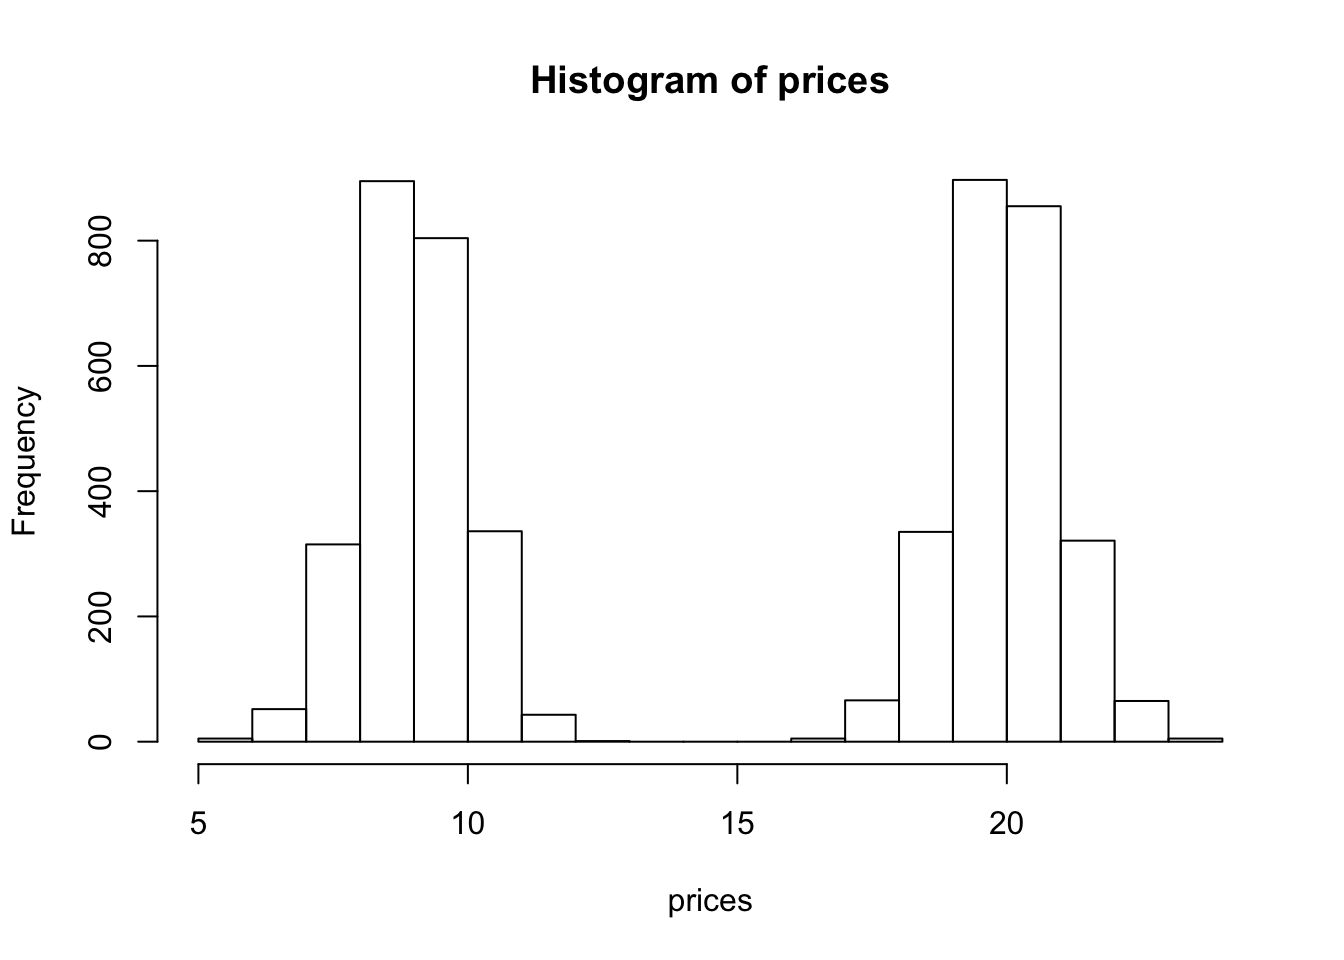

In [3]:
source="https://stephens999.github.io/fiveMinuteStats/figure/intro_to_mixture_models.Rmd/unnamed-chunk-1-1.png"

from IPython.display import Image
Image(source, height=500, width=500)

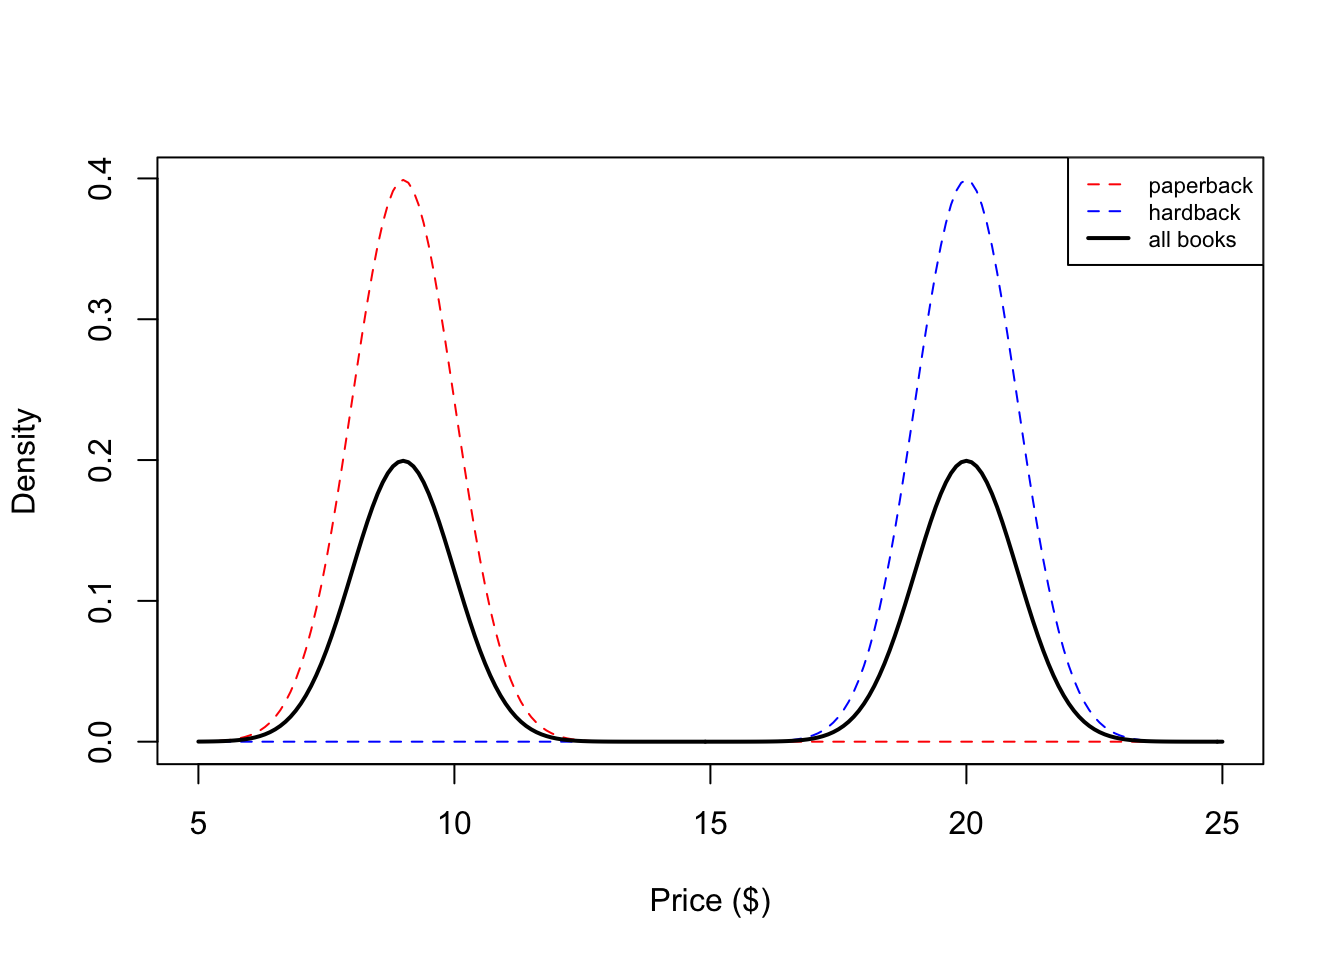

In [4]:
source='https://stephens999.github.io/fiveMinuteStats/figure/intro_to_mixture_models.Rmd/unnamed-chunk-2-1.png'
    
from IPython.display import Image
Image(source, height=500, width=500)

We see that the histogram is bimodal. Indeed, even though the mixture components are each normal distributions, the distribution of a randomly chosen book is not. Let's see another example:

##### Example:
Now assume that the data are the heights of students at the University of Chicago. Assume the height of a randomly chosen male is normally distributed with mean 5'9 and a standard deviation of 2.5 inches; the height of a randomly chosen female is normally distributed with mean 5'4 and standard deviation of 2.5 inches. Assume the mixing proportion right now is that 75% is female, and 25% is male. Let's simulate heights of the mixture components:

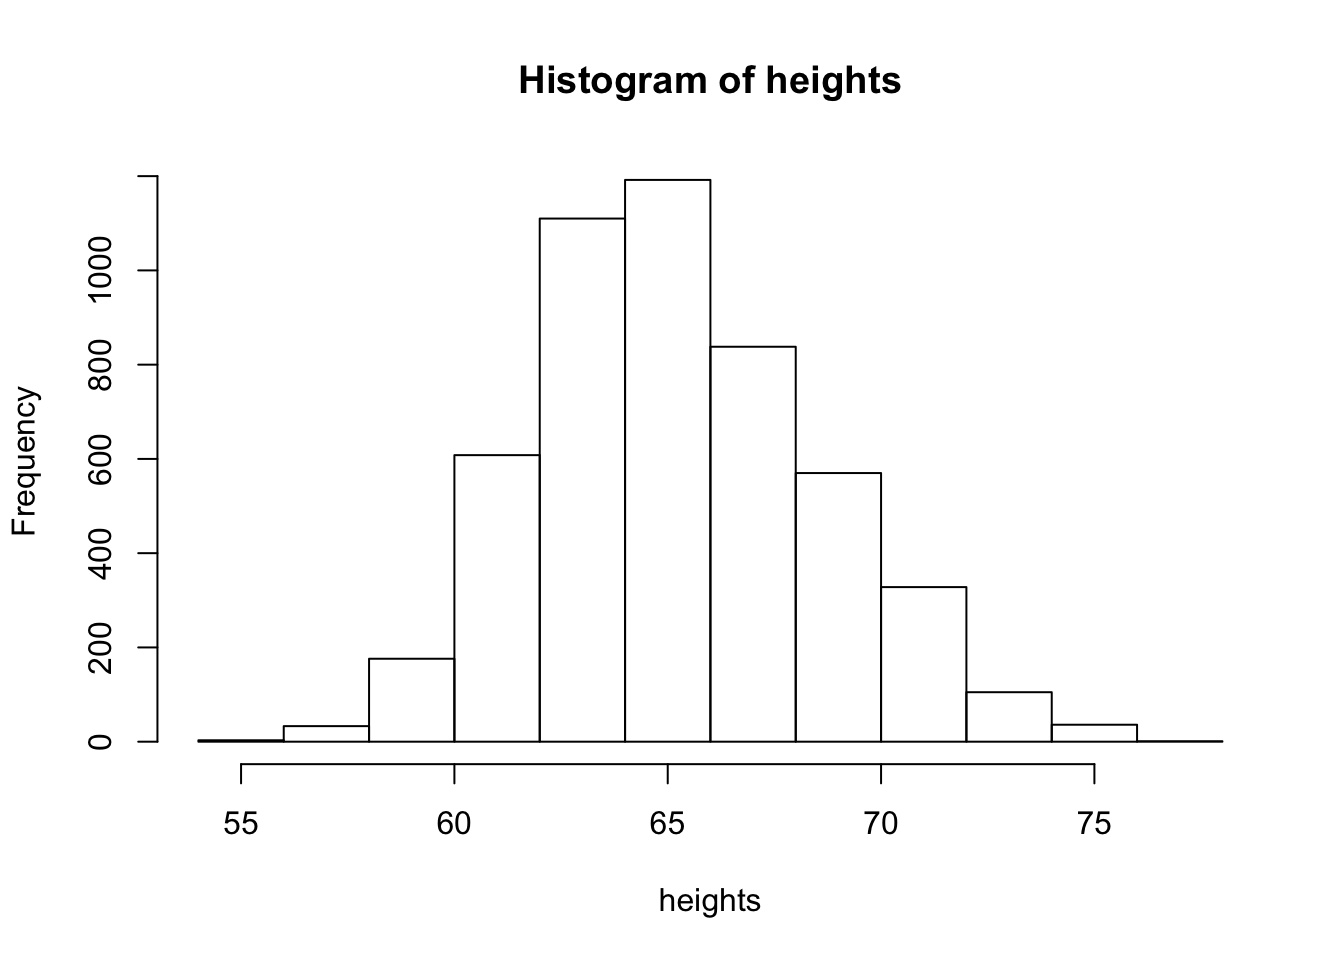

In [5]:
source='https://stephens999.github.io/fiveMinuteStats/figure/intro_to_mixture_models.Rmd/unnamed-chunk-3-1.png'
    
from IPython.display import Image
Image(source, height=500, width=500)

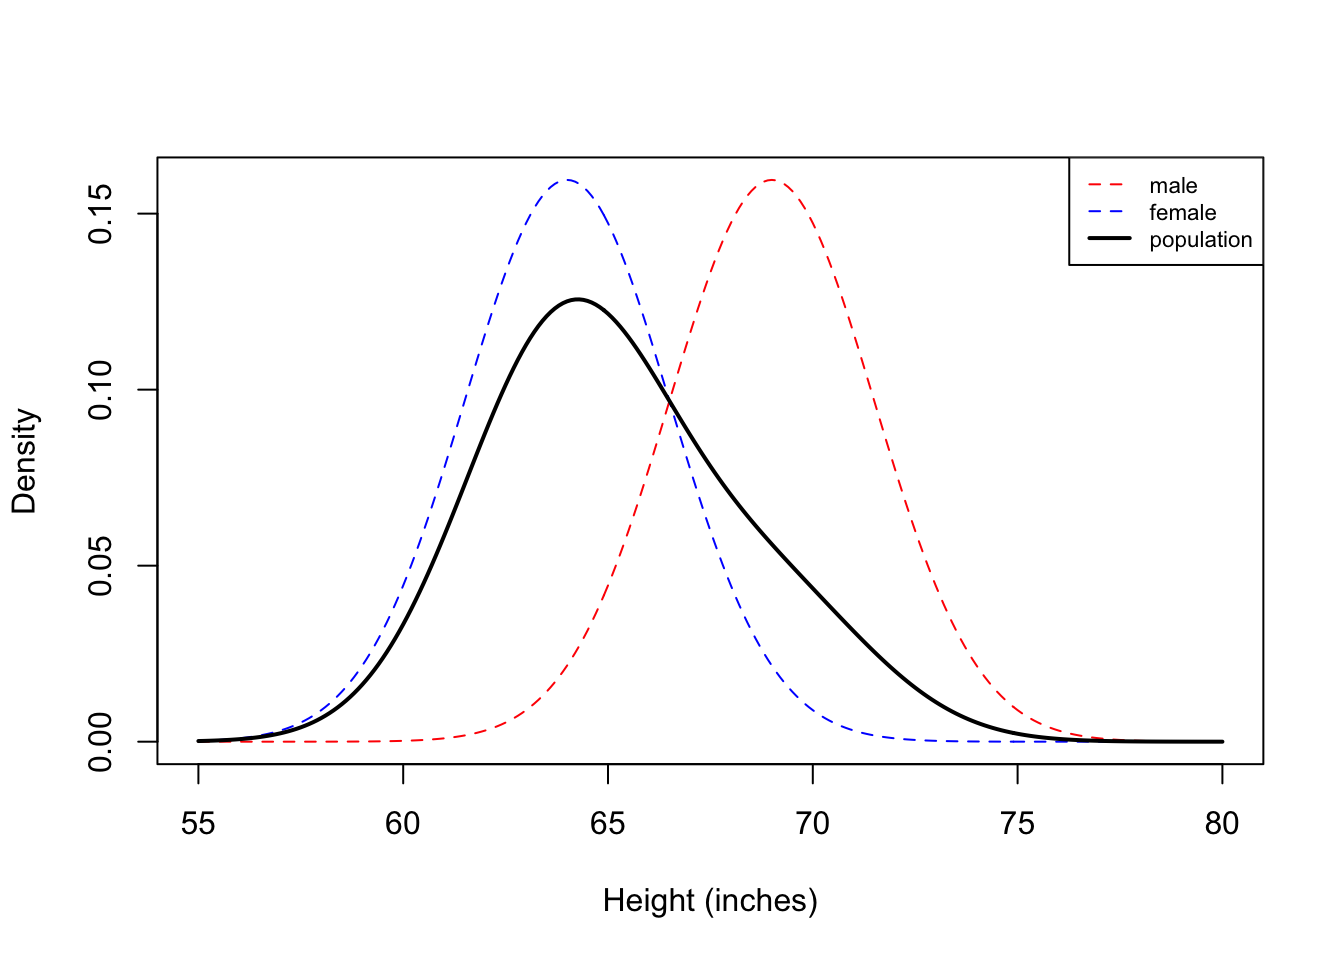

In [6]:
source='https://stephens999.github.io/fiveMinuteStats/figure/intro_to_mixture_models.Rmd/unnamed-chunk-4-1.png'

from IPython.display import Image
Image(source, height=500, width=500)

Now we see that the histogram is unimodal, and the mixture model is looks more like normal. Here, we see that the GM model is unimodal because there is so much overlap between these 2 densities. In this example, we see that the population density is not symmetric, therefore not normally distributed. 

In the example of above, we explicitly state the parameters of each distribution, as these are examples for simulation purposes. In reality, we don't usually know the parameters of these models and therefore need to estimate them. We immediately see that the problem can be solved by the EM algorithm (expectation-maximization) as we can treat $x$ as the complete data and $z$ as incomplete/missing data (latent). EM algorithm essentially sketches out an iterative process where we can gradually estimate the parameters $\pi_{j}, \mu_{j}, \sigma_{j}$ from observations $x$. In the E-step, by using the observed data to estimate or guess the values of the missing or incomplete data, we can get a partially complete data for the next step. In the M-step, we use teh partially complete data generated above to update the values of the parameters (the solution to the M-steps often exists in the closed-form). Here is a sketch of the EM-algorithm. Details of this algorithm can be found in standard textbooks such as that of Casella and Berger. Haugh (2015) also has a very comprehensive and readable review on EM-algorithms and its variants. 

##### The classical EM-Algorithm:
Let $x$ be observables and $z$ be latent. Set $w=(x,z)$ with parameter vector $\theta \in \Theta$. Denote the complete log-likelihood function by $log(L(\theta|w))$. For a generic step $s$:

   - E-step: compute the **responsibility** $r_{j}=Pr(z=j|x, \theta^{(s)})$. Then compute $Q(\theta^{(s+1)}, \theta^{(s)})=E[log(L(\theta^{(s+1)}|w))|x, \theta^{(s)}]=\int log(L(\theta^{(s+1)}|w))r_{j}dz$.
   - M-step: find $\theta^{(s+1)}=argmax_{\theta}Q(\theta, \theta^{(s)})$ (this is done by setting the criterion function's derivative to 0).
   -Repeat the following two steps above.
   
The EM algorithm works because of the intrinsic nature of convexity (Jensen's inequality). Solutions for EM algorithms are all local optimal. To achieve better results, EM algorithm can be run several times and then take the best result thereafter.

### III. K-Means vs. GM

Gaussian mixture model can be treated as a generalization of K-means model in that the latter requires that clustering be based on a radius (equal distance in all directions in the high-dimensional data space), whereas the GM model can be more flexible. In other words, K-means clustering places a circle (or, in higher dimensions, a hypersphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. So K-means has no built-in way of accounting for oblong or elliptical clusters. So if the true clusters should be non-circular, circular clusters made by K-means would be a poor fit.

In [7]:
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flipping axes for better plotting
print(type(X)) # this is an array object
print(X.shape)
print(y_true.shape)

rng = np.random.RandomState(13)
print("rng:", rng)
X_stretched = np.dot(X, rng.randn(2, 2))
print(X_stretched.shape)

<class 'numpy.ndarray'>
(400, 2)
(400,)
rng: RandomState(MT19937)
(400, 2)


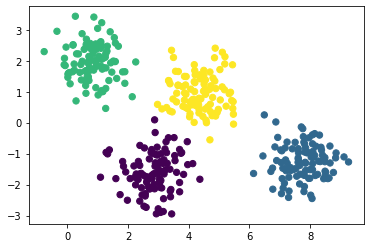

In [8]:
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

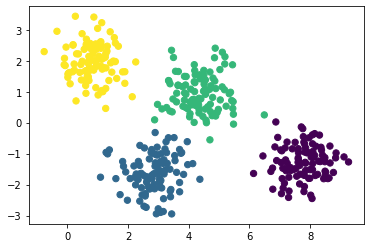

In [9]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

Compare this with the stretched data:

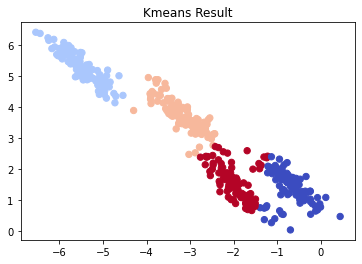

In [10]:
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X_stretched).predict(X_stretched)
plt.title("Kmeans Result")
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='coolwarm')

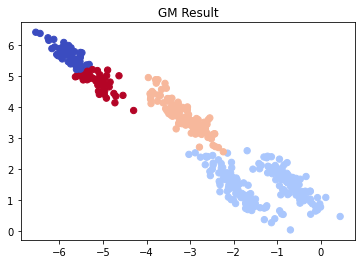

In [11]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(X_stretched)
labels = gmm.predict(X_stretched)
plt.title("GM Result")
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='coolwarm')

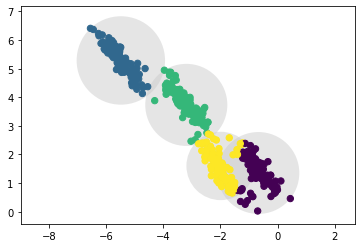

In [12]:
def plot_kmeans(kmeans, X, n_clusters, rseed, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X=X_stretched, n_clusters=4, rseed=0)

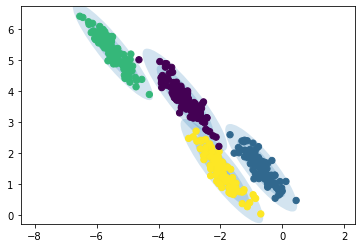

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, n_components, covariance_type, rs, label=True, ax=None):
    ax = ax or plt.gca()
    labels = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=rs).fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

gmm3= GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X_stretched)
plot_gmm(gmm3, X_stretched, n_components=4, covariance_type='full', rs=42)

We can use AIC and BIC to pick the optimal number of clusters for GM models:

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


C:\Users\gao\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


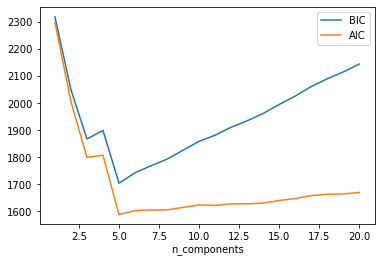

In [14]:
n_components = np.arange(1, 21)
print(n_components)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_stretched)
          for n in n_components]

plt.plot(n_components, [m.bic(X_stretched) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_stretched) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### IV. Real Data Example Using the Wine Dataset

#### i. EDA and Data Cleaning

We now go over a real example using the wine dataset to cluster different types of wines. The dataset contains a lot of chemical analysis of wines grown in a specific area of Italy. Attributes include alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavanoids etc. 

In [15]:
winebunch=load_wine(as_frame=True)
print(type(winebunch))
X=winebunch.data
y=winebunch.target
print(X.head(3))
print(y.head(3))

<class 'sklearn.utils.Bunch'>
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   

   od280/od315_of_diluted_wines  proline  
0                          3.92   1065.0  
1                          3.40   1050.0  
2                          3.17   1185.0  
0    0
1    0
2    0
Name: target, dtype: int32


Let's look at some EDA:

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

array([[<AxesSubplot:xlabel='alcohol', ylabel='alcohol'>,
        <AxesSubplot:xlabel='malic_acid', ylabel='alcohol'>,
        <AxesSubplot:xlabel='ash', ylabel='alcohol'>,
        <AxesSubplot:xlabel='alcalinity_of_ash', ylabel='alcohol'>,
        <AxesSubplot:xlabel='magnesium', ylabel='alcohol'>,
        <AxesSubplot:xlabel='total_phenols', ylabel='alcohol'>,
        <AxesSubplot:xlabel='flavanoids', ylabel='alcohol'>,
        <AxesSubplot:xlabel='nonflavanoid_phenols', ylabel='alcohol'>,
        <AxesSubplot:xlabel='proanthocyanins', ylabel='alcohol'>,
        <AxesSubplot:xlabel='color_intensity', ylabel='alcohol'>,
        <AxesSubplot:xlabel='hue', ylabel='alcohol'>,
        <AxesSubplot:xlabel='od280/od315_of_diluted_wines', ylabel='alcohol'>,
        <AxesSubplot:xlabel='proline', ylabel='alcohol'>],
       [<AxesSubplot:xlabel='alcohol', ylabel='malic_acid'>,
        <AxesSubplot:xlabel='malic_acid', ylabel='malic_acid'>,
        <AxesSubplot:xlabel='ash', ylabel='malic_acid'

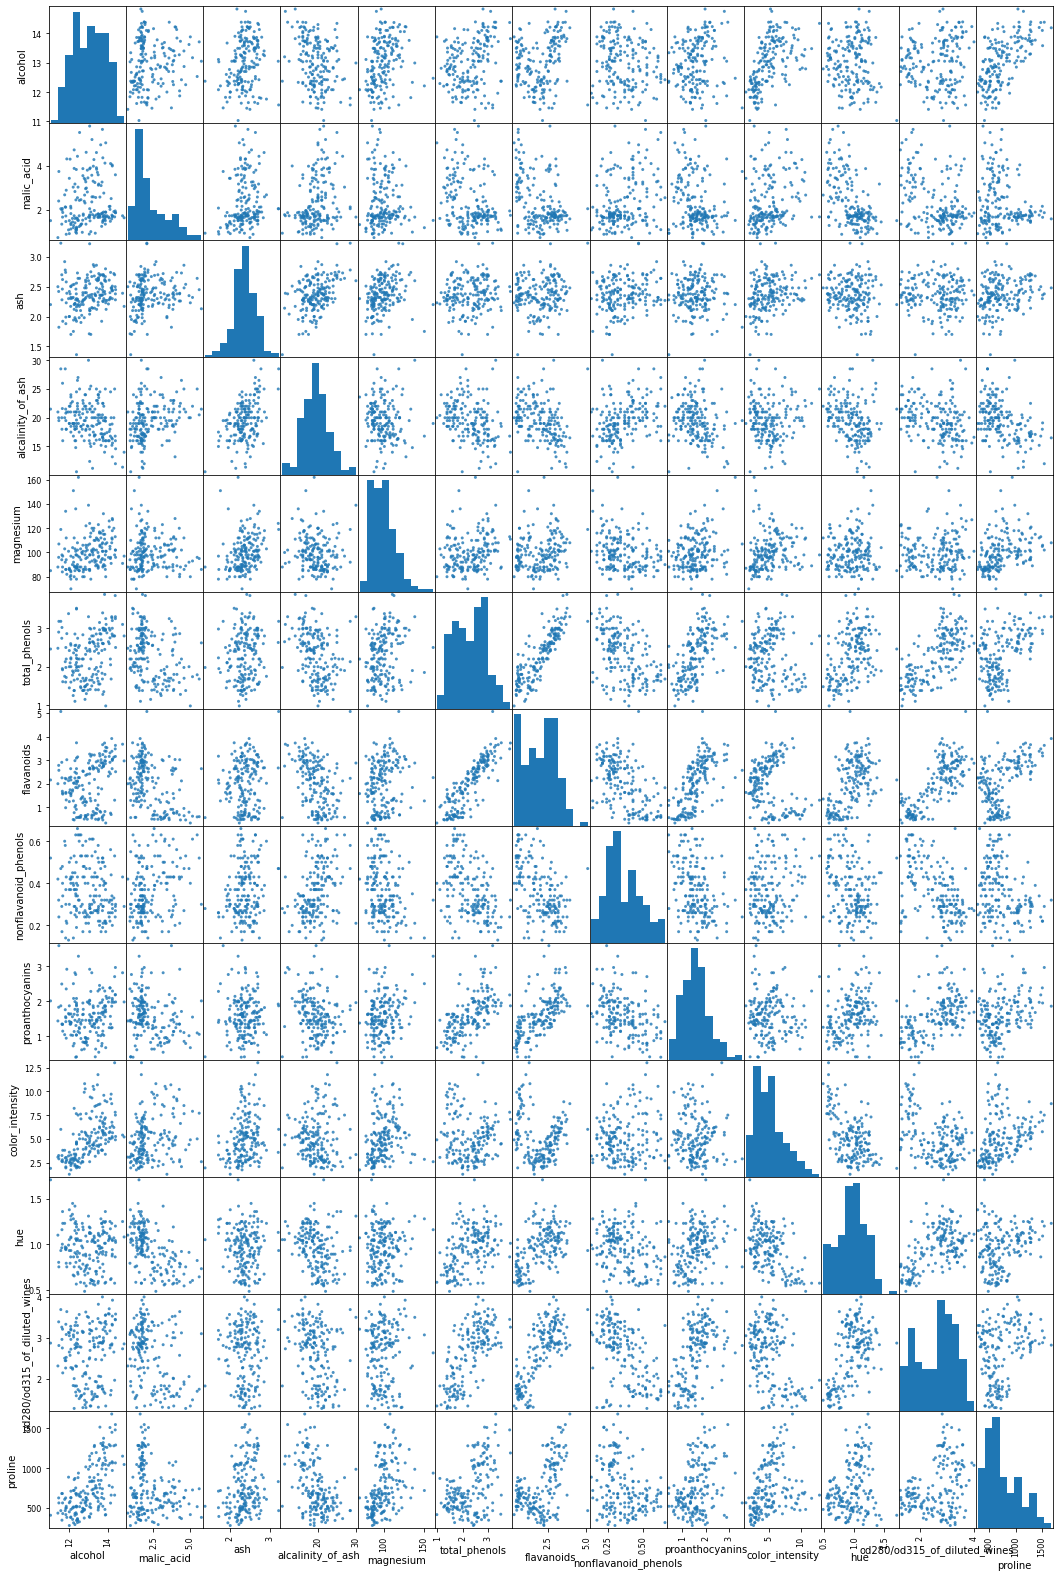

In [17]:
sm(X, alpha=0.8, figsize=(18,28))

<AxesSubplot:>

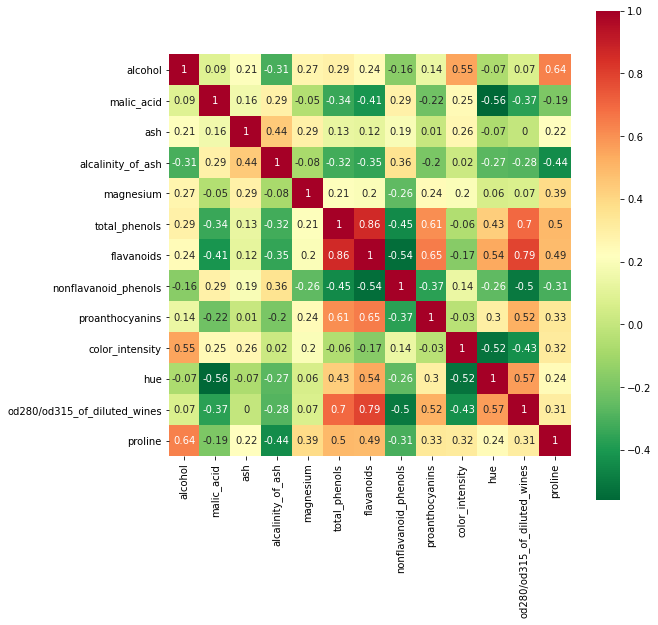

In [18]:
correlation=X.corr()
plt.subplots(figsize=(9,9))
sns.heatmap(correlation.round(2), annot=True, vmax=1, square=True, cmap='RdYlGn_r')

Now let's do the clustering. To start with, let's first conjecture how many clusters we need. One way to look at that is to look at the types of labels(target). The other way is to look at AIC/BIC (lowest) for model selection:

In [19]:
print('How many types of labels/responses are there in the dataset?\n', y.unique())

How many types of labels/responses are there in the dataset?
 [0 1 2]


#### ii. Selecting the Number of Clusters

We now try to select the number of clusters (one of the most important hyperparameters for GM). We will look at both AIC and BIC (smaller the better):

C:\Users\gao\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


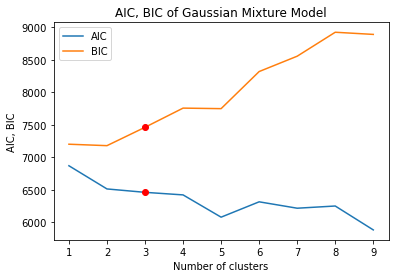

In [20]:
aic=dict()
bic=dict()
seed=0

for k in range(1,10):
    estimator=GaussianMixture(n_components=k, random_state=seed)
    result=estimator.fit(X) # X is the original dataset (DataFrame)
    ic1=estimator.aic(X)
    ic2=estimator.bic(X)
    aic[k]=ic1
    bic[k]=ic2
    
aic_df=pd.Series(aic) # generating a Series object based on the aic values
bic_df=pd.Series(bic)

temp={'AIC': aic_df, 'BIC': bic_df}
ic_df=pd.DataFrame(temp)
ax=ic_df.plot(title="AIC, BIC of Gaussian Mixture Model")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC, BIC')
plt.plot(3, aic_df[3], 'ro') # highlighting 3 
plt.plot(3, bic_df[3], 'ro')

We see that AIC and BIC diverged in different directions, which is an interesting pattern. Recall that these criteria are calculated as follows:
 
   - $AIC=2\kappa-2Log(\hat{L})$
   - $BIC=\kappa log(n)-2Log(\hat{L})$
   
where $\kappa$ indicates the number of parameters estimated by the model; $\hat{L}$ is the maximized value of the likelihood function of the model and $n$ is the sample size (see https://scikit-learn.org/stable/modules/linear_model.html#aic-bic). This is a hard topic, but one way to look at the data is to normalize the data before applying GM to choose the number of clusters:

In [21]:
scalar=preprocessing.StandardScaler()
scalar.fit(X)
X_scaled_array=scalar.transform(X)
Xnorm=pd.DataFrame(X_scaled_array, columns=X.columns)
Xnorm.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


C:\Users\gao\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


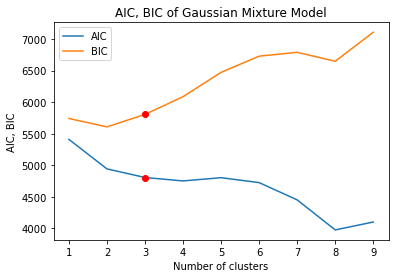

In [22]:
aic=dict()
bic=dict()
seed=0
for k in range(1,10):
    estimator=GaussianMixture(n_components=k, random_state=seed)
    result=estimator.fit(Xnorm) # Xnorm is the normalized dataset (DataFrame)
    ic1=estimator.aic(Xnorm)
    ic2=estimator.bic(Xnorm)
    aic[k]=ic1
    bic[k]=ic2
    
aic_df=pd.Series(aic) # generating a Series object based on the aic values
bic_df=pd.Series(bic)

temp={'AIC': aic_df, 'BIC': bic_df}
ic_df=pd.DataFrame(temp)
ax=ic_df.plot(title="AIC, BIC of Gaussian Mixture Model")
ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC, BIC')
plt.plot(3, aic_df[3], 'ro') # highlighting 3 
plt.plot(3, bic_df[3], 'ro')

As we see this time, the result becomes 'smoother' and from a model-averaging perspective, any number between 2-5 is acceptable. Thus the choice of 3 is reasonable. 

#### iii. Training the Model

Let's now train the GM model. In general, we do not need to standardize the data like how we handle K-Means etc. but for comparison reasons, we will look at both versions.

In [23]:
cluster_size=3

GM = GaussianMixture(n_components=cluster_size, covariance_type='full', random_state=seed)
result_GM=GM.fit(X)

weights_GM=GM.weights_
means_GM=GM.means_
Covariance_GM=GM.covariances_
print('weights_GM:\n', weights_GM)
print('means_GM:\n', means_GM) # the mean of each mixture component, (n_components, n_features)
print('Size of Covariance_GM:\n', Covariance_GM.size)
print('GM Model converged?', GM.converged_)

label_pred_GM = GM.predict(X)
print('Labels predicted by the Gaussian mixture model:\n', label_pred_GM)

############
print("\n--------------------\n")

GM2 = GaussianMixture(n_components=cluster_size, covariance_type='full', random_state=seed)
result_GM2=GM2.fit(Xnorm)

weights_GM2=GM2.weights_
means_GM2=GM2.means_
Covariance_GM2=GM2.covariances_
print('weights_GM2 (with normalized data):\n', weights_GM2)
print('means_GM2 (with normalized data):\n', means_GM2) # the mean of each mixture component, (n_components, n_features)
print('Size of Covariance_GM2 (with normalized data):\n', Covariance_GM2.size)
print('GM Model (with normalized data) converged?', GM2.converged_)

label_pred_GM2 = GM2.predict(Xnorm)
print('Labels predicted by the Gaussian mixture model (with normalized data):\n', label_pred_GM2)

weights_GM:
 [0.29789875 0.34586417 0.35623708]
means_GM:
 [[1.30152258e+01 2.99167919e+00 2.41774130e+00 2.03987866e+01
  1.02732859e+02 1.86485785e+00 1.01065378e+00 4.35909429e-01
  1.34993269e+00 6.45929341e+00 7.73457507e-01 1.99016898e+00
  6.77936558e+02]
 [1.36487205e+01 1.89301763e+00 2.44224824e+00 1.75027832e+01
  1.05792456e+02 2.81100844e+00 2.93666388e+00 2.94993944e-01
  1.88341313e+00 5.35438111e+00 1.07445213e+00 3.13311499e+00
  1.08634973e+03]
 [1.23591713e+01 2.21875795e+00 2.25015482e+00 2.06732696e+01
  9.13654548e+01 2.15403303e+00 2.00010159e+00 3.64839121e-01
  1.50840698e+00 3.59868735e+00 9.97714554e-01 2.62517401e+00
  4.74985241e+02]]
Size of Covariance_GM:
 507
GM Model converged? True
Labels predicted by the Gaussian mixture model:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 1 2 2 0 0 0 2 2 1
 0 2 2 2 0 2 2 1 2 2 0 1 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 1 2 2 2 2 2 2 0 2
 

In [38]:
# density_pred = GM.predict_proba(X)
# print(density_pred[0]) # label 1
# print(density_pred[176]) # label 0

let's pick 2 dimensions to look at the results:

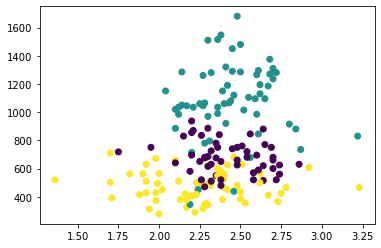

In [25]:
plt.scatter(x=X['ash'],y=X['proline'],c=label_pred_GM) # the argument 'c' stands for 'color'

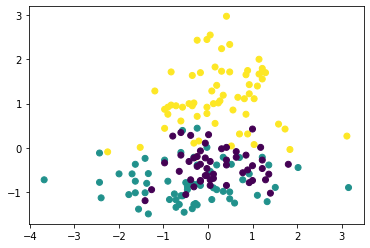

In [26]:
plt.scatter(x=Xnorm['ash'],y=Xnorm['proline'],c=label_pred_GM2) # the argument 'c' stands for 'color'

To visualize the results, we will need PCA (or manifold learning for more advanced visualization). Here let's look at LLE:

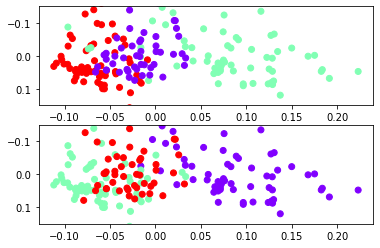

In [27]:
LLE = LocallyLinearEmbedding(n_neighbors=100, 
                             n_components=2, 
                             method='hessian',
                             eigen_solver='dense')
out = LLE.fit_transform(X) # visualizing all variables in 2D by preserving distances
fig, ax = plt.subplots(2, 1)
ax[0].scatter(out[:, 0], out[:, 1], c=label_pred_GM, cmap='rainbow')
ax[0].set_ylim(0.15, -0.15);
ax[1].scatter(out[:, 0], out[:, 1], c=y, cmap='rainbow')
ax[1].set_ylim(0.15, -0.15);

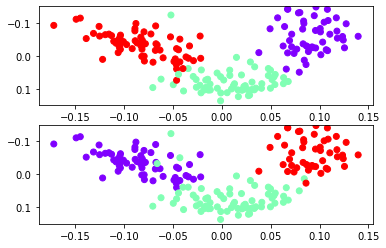

In [28]:
LLE2 = LocallyLinearEmbedding(n_neighbors=100, 
                             n_components=2, 
                             method='hessian',
                             eigen_solver='dense')
out2 = LLE2.fit_transform(Xnorm) # visualizing all variables in 2D by preserving distances
fig, ax = plt.subplots(2, 1)
ax[0].scatter(out2[:, 0], out2[:, 1], c=label_pred_GM2, cmap='rainbow')
ax[0].set_ylim(0.15, -0.15);
ax[1].scatter(out2[:, 0], out2[:, 1], c=y, cmap='rainbow')
ax[1].set_ylim(0.15, -0.15);

#### iv. Evaluation of the Models

To evaluate the model, let's look at the silhouette values. Recall that  the silhouette coefficient is a distance-based metric that evaluates the cohesion of clusters. The value of the silhouette coefﬁcient is between -1 and 1. A score of 1 denotes the best meaning that the data point $i$ is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Silhouette score of cluster by GM: 0.28326046005723704


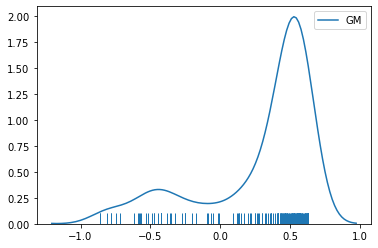

In [29]:
sihouette_score_GM=silhouette_score(X, label_pred_GM)
print("Silhouette score of cluster by GM:", sihouette_score_GM)
silhouette_score_sample_GM=silhouette_samples(X, label_pred_GM)
p1=sns.distplot(silhouette_score_sample_GM, hist=False, rug=True, label='GM')

Silhouette score of cluster by GM (using normalized data): 0.2844212860533542


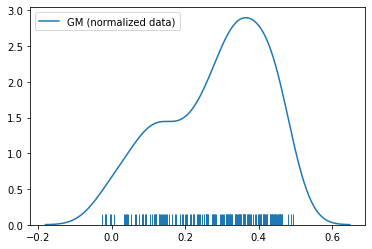

In [30]:
sihouette_score_GM2=silhouette_score(Xnorm, label_pred_GM2)
print("Silhouette score of cluster by GM (using normalized data):", sihouette_score_GM2)
silhouette_score_sample_GM2=silhouette_samples(Xnorm, label_pred_GM2)
p2=sns.distplot(silhouette_score_sample_GM2, hist=False, rug=True, label='GM (normalized data)')

The Rand index (RI) computes a similairity between 2 clusters by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusters.
The raw Rand index has a value between 0 and 1, with 0 indicating that the two data clusterings do not agree on any pair of points and 1 indicating that the data clusterings are exactly the same.
The raw RI score is then adjusted for cance into the adjusted Rand index (ARI) score using the following scheme: $ARI=\frac{RI-Expected\_RI}{max(RI)-Expected\_RI}$. The higher the Rand index is, the more precise the cluster is. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). ARI can be occasionally negative, indicating that the expected value exceeds the raw value.

In [31]:
ARI_score_GM=adjusted_rand_score(y, label_pred_GM)
print("Adjusted Rand index for cluster by GM:", ARI_score_GM)

ARI_score_GM2=adjusted_rand_score(y, label_pred_GM2)
print("Adjusted Rand index for cluster by GM (with normalized data):", ARI_score_GM2)

Adjusted Rand index for cluster by GM: 0.6074836799117163
Adjusted Rand index for cluster by GM (with normalized data): 0.8803997758776985


##### References:

   - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/
   - https://stephens999.github.io/fiveMinuteStats/intro_to_mixture_models.html
   - https://stephens999.github.io/fiveMinuteStats/intro_to_em.html
   - http://www.columbia.edu/~mh2078/MachineLearningORFE/EM_Algorithm.pdf
   - https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
   - https://github.com/vincent27hugh/Cluster-Kmeans-EMGMM-PCA/blob/master/main.ipynb
   - https://stats.stackexchange.com/questions/371333/is-it-important-to-make-a-feature-scaling-before-using-gaussian-mixture-model
   - https://scikit-learn.org/stable/modules/linear_model.html#aic-bic